# Set Up Environment

## Dependencies

In [1]:
import funct
import importlib
import numpy as np
import pandas as pd
import os
import IPython
import netCDF4 as nc
import  xarray as xr
from datetime import datetime, timedelta

## Set up global variables

In [2]:
# Recognize the current operating system
if os.name == "nt":  # Windows
    delimiter = "\\"
else:  # Unix or Linux
    delimiter = "/"

# Read and organize the data

## Read historical CCS data

Issues to solve:
- Incomplete data of June, 2021
- Data up to 2024/3/8, need to dynamically download data after this date

In [3]:
freq = 3

rela_path_base = f"Data{delimiter}Persian_CCS_201901_202403{delimiter}CCS_esmJSON_2024-03-08075032am_"


# Get the current working directory
current_dir = delimiter.join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split(delimiter)[-5:]
    )
# Get the parent directory path
parent_dir = os.path.dirname(os.path.dirname(current_dir))
# Might need to modify the prefix of the parent_dir if necessary depending on different OS and device
os.chdir("/users/"+parent_dir)
# Now, your current working directory is the parent folder.

df_list = []
first_iter = True
for month in funct.iterate_months(2019, 1, 2024, 3):
    rela_path = rela_path_base + month + ".nc"
    df_wrf = funct.create_time_series_dataframe(freq, rela_path)
    if first_iter:
        df_wrf = df_wrf.replace(-99,np.nan)
        cols_after_drop = df_wrf.dropna(axis=1, how='any').columns
        first_iter = False
    df_dropped = df_wrf[[col for col in cols_after_drop]]
    df_list.append(df_dropped)
df_ccs = pd.concat(df_list)
# orginal shape of the Esmeraldas basin is of size 53*52
# New flat array of 1098 pixels, showing only the net pixels of this basin area 

## Read data from Esmeraldas station
### Update ESM sensor data from ftp
Check the local path and download all the observations from ftp if it's not in the local folder yet

In [4]:
from ftplib import FTP
import os
from datetime import datetime, timedelta

local_base_folder = f"Data{delimiter}Esm_Station"
# local_base_folder = "Data/Esm_Station"


# FTP server details
ftp_server = "186.42.174.238"
username = "sistec"
password = "ftpst2012"

# Connect to the FTP server
ftp = FTP(ftp_server)
ftp.login(username, password)

# Change to the desired directory (optional)
# ftp.cwd(f"TEST_ESTACIONES_AUTOMATICAS{delimiter}H5033{delimiter}D1{delimiter}F10")
ftp.cwd("TEST_ESTACIONES_AUTOMATICAS/H5033/D1/F10")

# Find the latest date of existing files in the local folder
latest_local_date = None
for root, dirs, files in os.walk(local_base_folder):
    for file in files:
        if file.endswith(".csv"):
            file_date = datetime.strptime(file[:8], "%Y%m%d").date()
            if latest_local_date is None or file_date > latest_local_date:
                latest_local_date = file_date

# List all the files and folders in the current directory
files_and_folders = ftp.nlst()

# Filter out the folders starting with "yd"
yd_folders = [folder for folder in files_and_folders if folder.startswith("yd")]

for yd_folder in yd_folders:
    # Extract the year from the "yd" folder name
    yd_year = int(yd_folder[2:])
    
    # Check if the "yd" folder contains CSV files later than the latest local date
    if latest_local_date is None or yd_year >= latest_local_date.year:
        # Change to the "yd" folder
        ftp.cwd(yd_folder)
        files_and_folders = ftp.nlst()
        
        # Filter out the folders starting with "md"
        md_folders = [folder for folder in files_and_folders if folder.startswith("md")]
        
        for md_folder in md_folders:
            # Extract the year and month from the "md" folder name
            md_year = int(md_folder[2:6])
            md_month = int(md_folder[6:])
            
            # Check if the "md" folder contains CSV files later than the latest local date
            if latest_local_date is None or (md_year, md_month) >= (latest_local_date.year, latest_local_date.month):
                # Change to the "md" folder
                ftp.cwd(md_folder)
                
                # List all the CSV files in the current folder
                csv_files = [file for file in ftp.nlst() if file.endswith(".csv")]
                
                for csv_file in csv_files:
                    # Extract the date from the CSV file name
                    file_date = datetime.strptime(csv_file[:8], "%Y%m%d").date()
                    
                    # Set the specific time to be 23:55 of the file date
                    specific_datetime = datetime.combine(file_date, datetime.strptime("23:55", "%H:%M").time())
                    
                    # Add one day to the specific time
                    specific_datetime += timedelta(days=1)
                    
                    # Get the last modified time of the CSV file
                    last_modified_time = ftp.voidcmd(f"MDTM {csv_file}")[4:].strip()
                    last_modified_datetime = datetime.strptime(last_modified_time, "%Y%m%d%H%M%S")
                    
                    # Check if the last modified time is later than the specific time
                    if last_modified_datetime >= specific_datetime:
                        # Create the year and month folders if they don't exist
                        local_year_folder = os.path.join(local_base_folder, yd_folder)
                        local_month_folder = os.path.join(local_year_folder, md_folder)
                        os.makedirs(local_month_folder, exist_ok=True)
                        end_date = file_date  # use the date from the name of the most recent file
                        
                        # Check if the corresponding CSV file already exists
                        local_file_path = os.path.join(local_month_folder, csv_file)
                        if not os.path.exists(local_file_path):
                            # Download the CSV file to the local month folder
                            with open(local_file_path, "wb") as file:
                                # Use FTP's RETR command to download the file
                                ftp.retrbinary(f"RETR {csv_file}", file.write)
                            print(f"Downloaded {csv_file} to {local_month_folder}")
                    else:
                        print(f"Last modified time of {csv_file}: {last_modified_datetime} is not later than {specific_datetime}. Collection of sensor data unfinished. Skipping download.")
                
                ftp.cwd("..")  # Go back to the parent directory
        
        ftp.cwd("..")  # Go back to the parent directory

ftp.quit()

Downloaded 20240409_dvd.csv to Data\Esm_Station\yd2024\md202404
Downloaded 20240410_dvd.csv to Data\Esm_Station\yd2024\md202404
Downloaded 20240411_dvd.csv to Data\Esm_Station\yd2024\md202404
Downloaded 20240412_dvd.csv to Data\Esm_Station\yd2024\md202404
Downloaded 20240413_dvd.csv to Data\Esm_Station\yd2024\md202404
Downloaded 20240414_dvd.csv to Data\Esm_Station\yd2024\md202404
Downloaded 20240415_dvd.csv to Data\Esm_Station\yd2024\md202404
Downloaded 20240416_dvd.csv to Data\Esm_Station\yd2024\md202404
Last modified time of 20240417_dvd.csv: 2024-04-18 12:02:06 is not later than 2024-04-18 23:55:00. Collection of sensor data unfinished. Skipping download.
Last modified time of 20240418_dvd.csv: 2024-04-18 12:02:07 is not later than 2024-04-19 23:55:00. Collection of sensor data unfinished. Skipping download.


'221 Goodbye.'

### Read and organize the sensor data

In [5]:
funct = importlib.reload(funct)
from datetime import date, timedelta, datetime
from funct import format_number_with_zeros, diff, mmean
import chardet
import re

# Define start and end dates (replace with your desired dates)
start_date = date(2023, 2, 1)  # Adjust year, month, day as needed
# use the date from the name of the most recent file as the end_date, which is defined in the last cell


# Get the current working directory
current_dir = delimiter.join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split(delimiter)[-5:]
    )
# Get the parent directory path
parent_dir = os.path.dirname(os.path.dirname(current_dir))
# Change the directory (optional)
os.chdir("/users/"+parent_dir)
# Now, your current working directory is the parent folder.

# Iterate through each day using a for loop and timedelta

df_list_esm = []
df_list_esm_err = []

# iterate to read every .csv file and convert them into transposed dataframe to align with the form of ccs data
for day in range((end_date - start_date).days + 1):
    current_date = start_date + timedelta(days=day)
    # Do something with the current_date here (e.g., print, process data)
    year = current_date.year
    month = format_number_with_zeros(current_date.month,2)
    day = format_number_with_zeros(current_date.day,2)
    csv_path = f"Data{delimiter}Esm_Station{delimiter}yd{year}{delimiter}md{year}{month}{delimiter}{year}{month}{day}_dvd.csv"
    try:
        with open(csv_path, 'rb') as f:
            result = chardet.detect(f.read())
            encoding = result['encoding']
            df_wrf = pd.read_csv(csv_path, encoding= encoding, header = None ,skiprows=2)
            df_wrf = df_wrf[0].apply(lambda x: pd.Series(re.split(';', x)))
            df_wrf = df_wrf.T
            df_wrf.columns = df_wrf.iloc[0]
            head = df_wrf.iloc[0].values
            df_wrf = df_wrf.iloc[6:]
            df_wrf.drop(df_wrf.index[-1],inplace=True)
            df_wrf = df_wrf.set_index('N Sens', drop = True)
            times = [datetime.strptime(time, '%H.%M') for time in df_wrf.index]
            datetimes = [t.replace(year = year, month= current_date.month, day= current_date.day) for t in times]
            df_wrf.index = datetimes
            try:
                df_wrf.columns = ['hidro_level_m1','precip_acumu_sm','hidro_level_sm']
            except ValueError:
                df_wrf.columns = ['hidro_level_m1']
                # record the odd case with only data of a single sensor
                df_list_esm_err.append(df_wrf)
                print(current_date, head)
    # exception for missing data
    except FileNotFoundError:
        print(f"File not found: {csv_path}")
        encoding = None
        df_temp = df_wrf.copy()
        df_temp.index = df_temp.index + pd.Timedelta(days=1)
        df_temp.iloc[:, :] = np.nan
        df_wrf = df_temp.copy()
    df_list_esm.append(df_wrf)

# Normal run time > 4min

2023-10-01 ['N Sens' '78652']
2023-10-02 ['N Sens' '78652']
2023-10-03 ['N Sens' '78652']
2023-10-04 ['N Sens' '78652']
2023-10-05 ['N Sens' '78652']
2023-10-06 ['N Sens' '78652']
2023-10-12 ['N Sens' '78652']
2023-10-13 ['N Sens' '78652']
2023-10-14 ['N Sens' '78652']
2023-10-15 ['N Sens' '78652']
2023-10-16 ['N Sens' '78652']
2023-10-17 ['N Sens' '78652']
2023-10-18 ['N Sens' '78652']
2023-10-19 ['N Sens' '78652']
2023-10-20 ['N Sens' '78652']
2023-10-21 ['N Sens' '78652']
2023-10-22 ['N Sens' '78652']
2023-10-23 ['N Sens' '78652']
2023-10-24 ['N Sens' '78652']


In [6]:
# concat all the files
df_esm_all = pd.concat(df_list_esm)
# convert the data to be numeric
df_esm_all = df_esm_all.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == "object" else x)
# convert the values to approriate decimals
df_esm_all['hidro_level_m1'] = df_esm_all['hidro_level_m1']/100
df_esm_all['hidro_level_sm'] = df_esm_all['hidro_level_sm']/100
df_esm_all['precip_acumu_sm'] = df_esm_all['precip_acumu_sm']/1000
# aggregate data with a unit frequency of 3 hours, nan values will be excluded from the calculation
df_esm_all = df_esm_all.replace(-99.99,np.nan)
# the precipitation is a constantly accumulative value, the aggregation method should be the difference of the max and min value
df_esm_3h = df_esm_all.resample('180min').agg({'hidro_level_m1': 'mean', 'precip_acumu_sm': diff, 'hidro_level_sm':'mean'})
df_esm_3h = df_esm_3h.round(2)

# Initial Analysis of the sensor data

## Visualization of the data from the 3 sensors

In [7]:
import pandas as pd
import plotly
from plotly.graph_objs import Figure, Scatter

# Create the first trace
trace1 = Scatter(
    x=df_esm_3h.index,
    y=df_esm_3h['hidro_level_sm'],  # Assuming the first column is the data to plot
    mode='lines',
    name='San Mateo Station'  # Specify a name for the trace
)

# Create the second trace
trace2 = Scatter(
    x=df_esm_3h.index,
    y=df_esm_3h['hidro_level_m1'],  # Assuming the column name for the second data series
    mode='lines',
    name='Port Station'  # Specify a name for the second trace
)

# Define the layout
layout = {
    "title": "Water level of the river measured at different stations",
    "xaxis": {"title": "Date", "type": 'date'},
    "yaxis": {"title": "River level (m)"}
}

# Create the plot with both traces
fig = Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [8]:
from plotly.graph_objs import Bar

# Create the trace for the bar graph
trace3 = Bar(
    x=df_esm_3h.index,
    y=df_esm_3h['precip_acumu_sm'],  # Assuming the column is the data to plot
    name='Precipitation',  # Specify a name for the trace
)

# Define the layout
layout = {
    "title": "Precipitation measured at San Mateo station",
    "xaxis": {"title": "Date", "type": 'date'},
    "yaxis": {"title": "Precipitation (mm)"}
}

# Create the plot with the trace
fig = Figure(data=[trace3], layout=layout)
fig.show()

## Relationships of the data from the 3 sensors

### Correlations between the data of sensors

In [9]:
import pandas as pd
import plotly.graph_objects as go

# Create a sample DataFrame
df_sensor = df_esm_3h[['hidro_level_sm','hidro_level_m1','precip_acumu_sm']]

# Calculate the correlation matrix
corr_matrix = df_sensor.corr()

# Create a heatmap using plotly
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='RdBu',
    zmin=-1,
    zmax=1
))

# Update the layout
fig.update_layout(
    title='Correlation Heatmap',
    xaxis_title='Columns',
    yaxis_title='Columns'
)

# Display the plot
fig.show()

Random forest regression from the data of the other two stations to fill the gap of the data from the river level at San Mateo

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# y_true is the observed, y_pred is the y_pred
def nse(y_true, y_pred):
    return 1 - sum((y_pred - y_true)**2) / sum((y_true - np.mean(y_true))**2)

# Function to calculate Kling-Gupta Efficiency
def kge(y_true, y_pred):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    alpha = np.std(y_pred) / np.std(y_true)
    beta = np.sum(y_pred) / np.sum(y_true)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

# Split the DataFrame into features (X) and target variable (y)
X = df_esm_3h[['hidro_level_m1', 'precip_acumu_sm']]
y = df_esm_3h['hidro_level_sm']

# Drop rows with missing values in X and y
df_dropped_na = df_esm_3h.dropna()
X_train_full = df_dropped_na[['hidro_level_m1', 'precip_acumu_sm']]
y_train_full = df_dropped_na['hidro_level_sm']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.2, train_size=0.8, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [10, 15, 20, 30],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 5, 10, 15]
}

# Create a random forest regressor
rf_regressor = RandomForestRegressor(bootstrap=True, n_jobs=-2, random_state=42, max_features='sqrt')

# Perform grid search with custom scoring function
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring=make_scorer(nse, greater_is_better=True))
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)
# Predicting discharge
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculating metrics
nse_train = nse(y_train, y_train_pred)
nse_test = nse(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
kge_train = kge(y_train, y_train_pred)
kge_test = kge(y_test, y_test_pred)

# Outputting the metrics
print(f"Training NSE: {nse_train}, MSE: {mse_train}, KGE: {kge_train}")
print(f"Testing NSE: {nse_test}, MSE: {mse_test}, KGE: {kge_test}")

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 100}
Training NSE: 0.08267796163893593, MSE: 1.1933037290682997, KGE: -0.06526563110107642
Testing NSE: -0.03369335958098452, MSE: 1.3226103174096961, KGE: -0.2857451865594438


### ML methods
Use the fitted model to estimate the missing values of the river level data of the sensor at San Mateo station

In [11]:
# Create a new DataFrame with rows where y has missing values
X_missing = X[y.isnull()]
missing_index = y[y.isnull()].index

# Predict missing values in y using the best model
y_missing_pred = best_model.predict(X_missing)

# Create traces for the original observation values and fitted missing values
trace_obs = go.Scatter(x=y.index, y=y, mode='lines', name='Observation Values')
trace_filled = go.Scatter(x=missing_index, y=y_missing_pred, mode='lines', name='Fitted Missing Values')

# Create the plot layout
layout = go.Layout(title='Time Series Plot of water level measured at the San Mateo station',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='river level (m)'))

# Create the figure and add the traces
fig = go.Figure(data=[trace_obs, trace_filled], layout=layout)

# Display the plot
fig.show()

Remark:
- The fitted result of the missing values of the water level measured at the San Mateo station failed to capture the real features of the original observed time series
- Entonces, we will just ignore the missing data of the data of the San Mateo water level sensor

## Time series analysis and modeling of the SM water level data

### Check Stationarity

In [12]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(df_esm_3h.dropna()['hidro_level_sm'])

# Print the test results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value:.3f}")

# Check if the time series is stationary
if result[1] < 0.05:
    print("The time series is stationary")
else:
    print("The time series is non-stationary")

ADF Statistic: -3.330955549913317
p-value: 0.013550206150380531
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
The time series is stationary


### Determine the model and its parameters

#### Original dataset

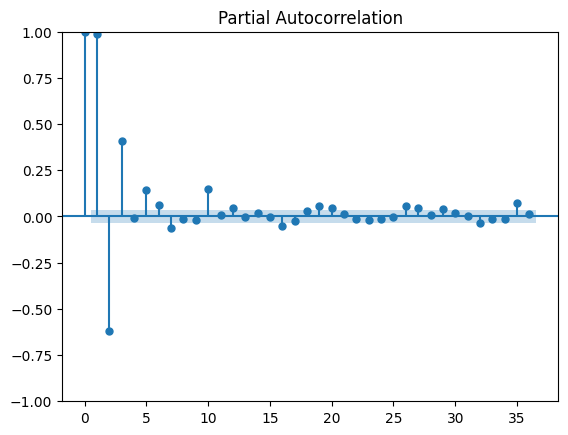

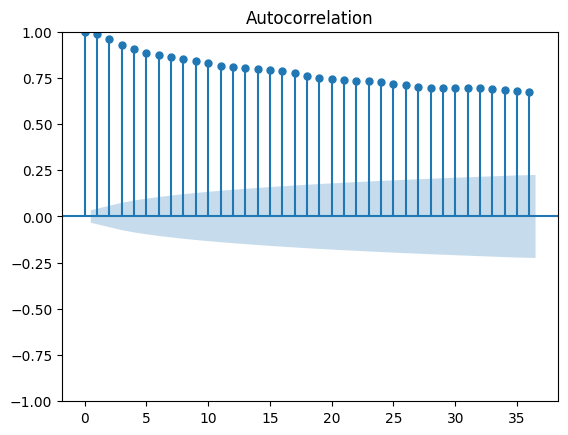

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt

level_sm = df_esm_3h['hidro_level_sm']
level_sm.dropna(inplace=True)
plot_pacf(level_sm, method='ywm');
plot_acf(level_sm);

Remark:
- PACF 
  - displays a significant lag of 3
  - lag of 4 and 10 are also relativey siginificant
- ACF: displays no siginificant MA(p) patterns
- Conclusion: it's solely a AR(4) model

#### Analysis of the first-order difference model

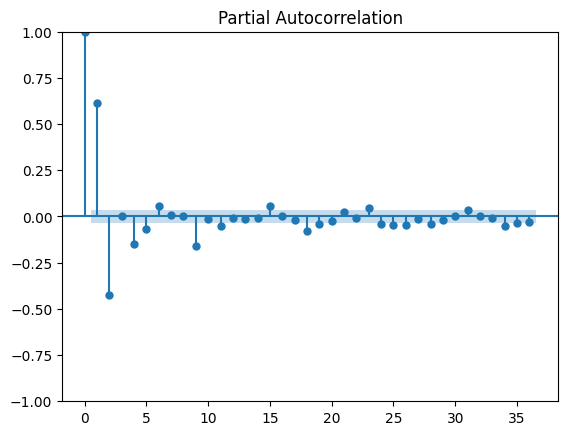

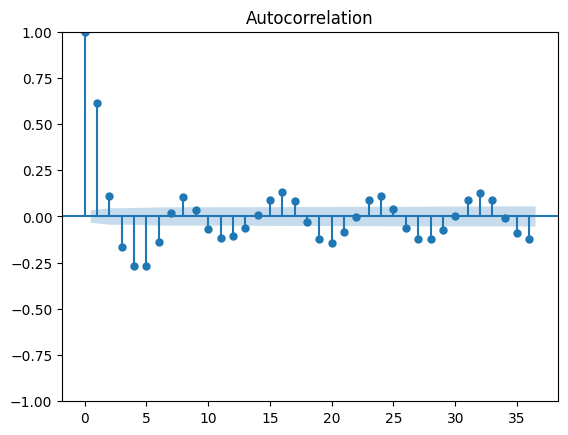

In [14]:
df_esm_3h_diff = df_esm_3h.dropna().diff()
df_esm_3h_diff.dropna(inplace=True)
plot_pacf(df_esm_3h_diff['hidro_level_sm']);
plot_acf(df_esm_3h_diff['hidro_level_sm']);

Remarks:
- PACF showing significant lag of 3
- ACF cuts off at lag of 1, but with remaining lags of periodicity

# Merge the dataset

## Read the wrf data

### Display the numeric properties to find the potential problem of this dataset

In [67]:
# Get the current working directory
current_dir = delimiter.join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split(delimiter)[-5:]
    )
# Get the parent directory path
parent_dir = os.path.dirname(os.path.dirname(current_dir))
# Might need to modify the prefix of the parent_dir if necessary depending on different OS and device
os.chdir("/users/"+parent_dir)
# Now, your current working directory is the parent folder.
df_wrf = pd.read_csv(f'Data{delimiter}prec_time_series.csv')

In [114]:
df_wrf['datetime'] = pd.to_datetime(df_wrf['date'] + ' ' + df_wrf['time'])
df_wrf.set_index('datetime', inplace=True)
df_wrf.drop(columns=df_wrf.columns[:2], inplace=True)
df_wrf.index = df_wrf.index - pd.DateOffset(hours=1)
df_wrf.head()

,pixel14,pixel90,pixel91,pixel92,pixel93,pixel94,pixel166,pixel167,pixel168,pixel169,...,pixel5744,pixel5816,pixel5817,pixel5818,pixel5819,pixel5820,pixel5821,pixel5895,pixel5896,pixel5973
datetime,,,,,,,,,,,,,,,,,,,,,
2019-06-19 21:00:00,0.000881,0.001858,0.002225,0.000948,2.543916e-05,0.000000e+00,2.903598e-08,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-19 00:00:00,0.019255,0.021751,0.028279,0.024916,2.657130e-02,0.000000e+00,7.307045e-03,0.073192,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-19 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-19 06:00:00,0.040779,0.471003,0.177239,0.098497,1.111284e-01,1.440982e-02,1.662926e-01,0.318898,0.104849,0.024595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-19 09:00:00,0.002563,0.000068,0.000001,0.000001,1.773238e-07,4.759058e-07,4.200739e-03,0.000231,0.000002,0.000005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Alter the dataset

In [162]:
def keep_5th_and_12th(group):
    # Get the rows from 5th to 12th
    filtered_group = group.iloc[4:12, :]
    
    # Get the index of the filtered group
    index = filtered_group.index
    
    # Create a new index with modified timestamps
    new_index = []
    for i, timestamp in enumerate(index):
        if i >= 5:  # If the row index is >= 9 (10th row and beyond)
            new_index.append(timestamp + pd.Timedelta(days=1))
        else:
            new_index.append(timestamp)
    
    # Update the index of the filtered group
    filtered_group.index = new_index
    
    return filtered_group

df_wrf_filterd = df_wrf.groupby(df_wrf.index.date).apply(keep_5th_and_12th)

In [205]:
print(f"The dataset has {df_wrf_filterd.shape[0]} rows")
print(f"The dataset's index has {len(df_wrf_filterd.index.levels[1])} values")
print(f"There are {df_wrf_filterd.shape[0]-len(df_wrf_filterd.index.levels[1])} duplicate values of the index")

The dataset has 9176 rows
The dataset's index has 9168 values
There are 8 duplicate values of the index


In [210]:
df_wrf_filterd['datetime'] = df_wrf_filterd.index.get_level_values(1)
duplicates = df_wrf_filterd.duplicated(subset=['datetime'])
df_wrf_filterd[duplicates]
print(f"The duplicate rows are:\n{df_wrf_filterd[duplicates]['datetime'].values}")

The duplicate rows are:
['2023-03-14T00:00:00.000000000' '2023-03-14T03:00:00.000000000'
 '2023-03-14T03:00:00.000000000' '2023-03-14T06:00:00.000000000'
 '2023-03-14T06:00:00.000000000' '2023-03-15T09:00:00.000000000'
 '2023-03-15T09:00:00.000000000' '2023-03-15T12:00:00.000000000']


In [227]:
df_wrf_filterd.index = df_wrf_filterd.index.rename(['date', 'time'])
date_obj = datetime.date(year = 2019, month = 6, day = 19)
filtered_df = df_wrf_filterd.xs(date_obj, level='date')

TypeError: unbound method datetime.date() needs an argument

In [229]:
a = date(year = 2019, month = 6, day = 19)

In [230]:
a

datetime.date(2019, 6, 19)

In [178]:
df_wrf_filterd.index.levels[1]

DatetimeIndex(['2019-06-19 09:00:00', '2019-06-19 12:00:00',
               '2019-06-19 15:00:00', '2019-06-19 18:00:00',
               '2019-06-19 21:00:00', '2019-06-20 00:00:00',
               '2019-06-20 03:00:00', '2019-06-20 06:00:00',
               '2019-06-20 09:00:00', '2019-06-20 12:00:00',
               ...
               '2024-03-13 03:00:00', '2024-03-13 06:00:00',
               '2024-03-13 09:00:00', '2024-03-13 12:00:00',
               '2024-03-13 15:00:00', '2024-03-13 18:00:00',
               '2024-03-13 21:00:00', '2024-03-14 00:00:00',
               '2024-03-14 03:00:00', '2024-03-14 06:00:00'],
              dtype='datetime64[ns]', length=9168, freq=None)

In [179]:
df_wrf_filterd.index.levels[0]

Index([2019-06-19, 2019-06-20, 2019-06-22, 2019-06-24, 2019-06-25, 2019-06-26,
       2019-07-01, 2019-07-02, 2019-07-08, 2019-07-12,
       ...
       2024-03-04, 2024-03-05, 2024-03-06, 2024-03-07, 2024-03-08, 2024-03-09,
       2024-03-10, 2024-03-11, 2024-03-12, 2024-03-13],
      dtype='object', length=1147)

In [190]:
# Check for missing values in the second level (assuming 'time')
print(df_wrf_filterd.index.levels[1].isnull().sum())

# If there are missing values, consider filling them
if df_wrf_filterd.index.levels[1].isnull().sum() > 0:
  filled_df = df_wrf_filterd.set_index(['time'], append=True).sort_index(level='time')
  filled_df = filled_df.fillna(method='ffill')  # Fill missing values with previous value
  df_wrf_filterd = filled_df.copy()  # Update the DataFrame with filled values

# Try setting the index again after handling missing values (if any)
try:
  df_with_new_index = df_wrf_filterd.set_index(df_wrf_filterd.index.levels[1])
  print(df_with_new_index)
except ValueError:
  print("Length mismatch issue persists. Investigate further.")


0
Length mismatch issue persists. Investigate further.


In [191]:
import pandas as pd
import numpy as np

iterables = [['bar', 'baz', 'foo', 'qux'], ['one', 'two']]
mult_index  = pd.MultiIndex.from_product(iterables, names=['first', 'second'])
df = pd.DataFrame(np.random.randn(8, 3), index=mult_index, columns=['A', 'B', 'C'])

mult_index # same as df.index

MultiIndex([('bar', 'one'),
            ('bar', 'two'),
            ('baz', 'one'),
            ('baz', 'two'),
            ('foo', 'one'),
            ('foo', 'two'),
            ('qux', 'one'),
            ('qux', 'two')],
           names=['first', 'second'])

In [194]:
df['index_val1'] = df.index.get_level_values(1)
df

A         B         C index_val1
first second                                         
bar   one     0.496714 -0.138264  0.647689        one
      two     1.523030 -0.234153 -0.234137        two
baz   one     1.579213  0.767435 -0.469474        one
      two     0.542560 -0.463418 -0.465730        two
foo   one     0.241962 -1.913280 -1.724918        one
      two    -0.562288 -1.012831  0.314247        two
qux   one    -0.908024 -1.412304  1.465649        one
      two    -0.225776  0.067528 -1.424748        two

In [139]:
import pandas as pd

# Create a sample DataFrame with MultiIndex
data = [['A', 1, 'X', 10], ['A', 1, 'Y', 20], ['A', 2, 'X', 30], ['B', 1, 'X', 40], ['B', 2, 'Y', 50]]
df = pd.DataFrame(data, columns=['Group', 'Item', 'Category', 'Value'])
df = df.set_index(['Group', 'Item', 'Category'])

# Select rows based on the outer level of the index (Group)
filtered_df_outer = df.loc['A']
print("Filtered by outer level of the index (Group='A'):")
print(filtered_df_outer)

# Select rows based on multiple levels of the index
filtered_df_multiple = df.loc[('A', 1), :]
print("\nFiltered by multiple levels of the index (Group='A', Item=1):")
print(filtered_df_multiple)

# Select rows and columns based on the index
filtered_df_rows_cols = df.loc[('A', 2, 'X'), 'Value']
print("\nFiltered by rows and columns (Group='A', Item=2, Category='X'):")
print(filtered_df_rows_cols)

Filtered by outer level of the index (Group='A'):
               Value
Item Category       
1    X            10
     Y            20
2    X            30

Filtered by multiple levels of the index (Group='A', Item=1):
          Value
Category       
X            10
Y            20

Filtered by rows and columns (Group='A', Item=2, Category='X'):
30


In [52]:

# Replace negative values with 0
df_wrf[df_wrf < 0] = 0

# Drop columns containing NaN values
df_wrf = df_wrf.dropna(axis=1, how='any')
df_wrf.shape

(29829, 2416)

Merge the ccs data and Esmeradals data from CAE together and output to the local .csv file

In [55]:
df_merged = pd.merge(df_ccs, df_wrf, left_index=True, right_index=True, how='outer')
df_merged = pd.merge(df_merged, df_esm_3h, left_index=True, right_index=True, how='outer')
df_merged.shape
# shape of (time, 2759), where 2759 = 53*52 (# of pixels de Esm basin ) + 3 (# of sensors)

# start = str(df_merged.index[0].date())
# end  = str(df_merged.index[-1].date())
# df_merged.to_csv(f'merged_{start}_{end}.csv', compression= None)
# (44875, 3719)


(36076, 3517)

Before merging:
- df_ccs.shape = (14710,1098)
  - range from *2019-01-01 00:00:00* to *2024-03-05 09:00:00* with a frequency of 3h
  - 1098 columns representing 1098 valid pixels of the Esmeraldas basin (Originally 53*52=2756 pixels including null pixels)
- df_esm.shape = (3504,3)
  - range from *2023-02-01 00:00:00* to up to today
  - 3 columns representing data of 3 sensors
- df_wrf.shape = (29829,2416)
  - actually range from *2019-06-19 21:00:00* to *2024-03-14 01:00:00* with a frequency of 3h
  - here shifted 1 hour ahead to align with the time inedx form of df_ccs for a more matched merging
  - 2618 columns? with a different resolution


After mergeing
- df_merged.shape = (36052, 3517)
- 36052 = 

In [66]:
df_wrf.loc["2019-06-19 21:00:00	"]

,pixel14,pixel90,pixel91,pixel92,pixel93,pixel94,pixel166,pixel167,pixel168,pixel169,...,pixel4447,pixel4448,pixel4449,pixel4450,pixel4451,pixel4452,pixel4453,pixel4454,pixel4506,pixel4507
datetime,,,,,,,,,,,,,,,,,,,,,
2019-06-19 21:00:00,0.000881,0.001858,0.002225,0.000948,0.000025,0.0,2.903598e-08,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-06-19 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.551115e-17,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000006,0.000000,0.000000,0.000000,0.0,0.0
2019-06-19 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.551115e-17,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,4.441262,1.952892,0.0,0.0
2019-06-19 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.551115e-17,0.0,0.0,0.0,...,0.0,0.0,0.0,2.948858,0.000000,0.147932,1.571160,5.833664,0.0,0.0


# ML Model

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

# Function to calculate Nash-Sutcliffe Efficiency
def nse(observed, simulated):
    return 1 - sum((simulated-observed)**2)/sum((observed-np.mean(observed))**2)

# Function to calculate Kling-Gupta Efficiency
def kge(observed, simulated):
    r = np.corrcoef(observed, simulated)[0, 1]
    alpha = np.std(simulated) / np.std(observed)
    beta = np.sum(simulated) / np.sum(observed)
    return 1 - np.sqrt((r-1)**2 + (alpha-1)**2 + (beta-1)**2)

def create_lagged_features(df, column_name, max_lag):
    for lag in range(1, max_lag + 1):
        df[f'{column_name}_lag_{lag}'] = df[column_name].shift(lag)
    return df

In [64]:
df_merged.dropna()

,60,111,112,113,114,162,163,164,165,166,...,pixel4450,pixel4451,pixel4452,pixel4453,pixel4454,pixel4506,pixel4507,hidro_level_m1,precip_acumu_sm,hidro_level_sm
2023-02-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.421023e+00,2.953524e+00,2.009426,1.403432e+00,1.458720,2.231816e+00,1.544947,2.32,0.0,5.60
2023-02-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.822845e-05,0.000000e+00,0.000257,0.000000e+00,0.000000,0.000000e+00,0.000000,2.32,0.0,5.60
2023-02-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,2.32,0.0,5.60
2023-02-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,2.32,0.0,5.60
2023-02-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.029046e-01,1.122284e-02,0.480561,2.313514e-01,0.075522,2.385283e-01,0.105324,1.41,0.0,5.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.383525e-06,3.668666e-05,0.000007,3.537536e-05,0.000194,5.205199e-04,0.008205,1.56,0.0,6.85
2024-03-05 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.437962e-06,9.059906e-06,0.000000,1.177192e-06,0.000000,1.892447e-06,0.000000,1.56,0.0,6.85
2024-03-05 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.539041e-07,2.166724e-03,0.000003,6.705523e-07,0.000186,5.215406e-08,0.000746,2.22,0.0,7.13
2024-03-05 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,4.172325e-07,0.000000,0.000000e+00,0.000000,7.450581e-09,0.000000,2.22,0.0,7.13


In [63]:
365*8

2920

In [23]:
# add a column of Y's roling average
df_merged['y_rolling_avg'] = df_merged['hidro_level_sm'].rolling(window=3, min_periods=1).mean()

# Choose a lag value
max_lag = 5  # For example, you can use a lag of 3 time steps

# Create lagged features for the 'Discharge' column
df_merged = create_lagged_features(df_merged, 'hidro_level_sm', max_lag)

# Drop rows with NaN values that were created by shifting to create lagged features
df_merged = df_merged.dropna()
print(f"Shape of the final dataset is {df_merged.shape}\n")
# Preparing data
X = df_merged.drop(columns='hidro_level_sm')
y = df_merged['hidro_level_sm']
dates = df_merged.index

# Splitting data (70% training, 30% testing) sequentially
train_size = 0.7
split_index = int(len(X) * train_size)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
dates_train, dates_test = dates[:split_index], dates[split_index:]

split_index = int(len(X) * train_size)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
dates_train, dates_test = dates[:split_index], dates[split_index:]

# Training the Random Forest model
model = RandomForestRegressor(
    n_estimators=150,  # Increased from 100 for potentially better performance
    max_depth=20,  # Adjust as needed based on the complexity of your data
    min_samples_split=10,  # Helps to prevent overfitting on minor details
    min_samples_leaf=5,  # Ensures that leaves have a minimum number of samples
    max_features='sqrt',  # Auto setting for regression typically uses all features, consider "sqrt" or "log2" for high-dimensional data
    bootstrap=True,  # Keep bootstrap sampling to True for general usage
    n_jobs = -2
)
model.fit(X_train, y_train)

# Predicting discharge
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculating metrics
nse_train = nse(y_train, y_train_pred)
nse_test = nse(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
kge_train = kge(y_train, y_train_pred)
kge_test = kge(y_test, y_test_pred)

# Outputting the metrics
print(f"Training NSE: {nse_train}, MSE: {mse_train}, KGE: {kge_train}")
print(f"Testing NSE: {nse_test}, MSE: {mse_test}, KGE: {kge_test}")


Shape of the final dataset is (0, 3725)



TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [ ]:

# Plotting observed vs. predicted discharge for training period
plt.figure(figsize=(10, 6))
plt.plot(dates_train, y_train, label='Observed', color='blue')
plt.plot(dates_train, y_train_pred, label='Simulated', color='red')
plt.title(f"Training Period: Observed vs. Simulated Discharge\nNSE: {nse_train:.2f}, MSE: {mse_train:.2f}, KGE: {kge_train:.2f}")
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting observed vs. predicted discharge for testing period
plt.figure(figsize=(10, 6))
plt.plot(dates_test, y_test, label='Observed', color='blue')
plt.plot(dates_test, y_test_pred, label='Simulated', color='red')
plt.title(f"Testing Period: Observed vs. Simulated Discharge\nNSE: {nse_test:.2f}, MSE: {mse_test:.2f}, KGE: {kge_test:.2f}")
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()